# Analyzing New York City Taxi Data
### Import the necessary libraries for data analysis and processing

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, countDistinct, lit, col, lead, lag, unix_timestamp
from pyspark.sql.types import *
from pyspark.sql.window import Window
from shapely.geometry import Point, Polygon
import json
from shapely.geometry import shape
from shapely import ops
from shapely.ops import transform
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from functools import partial
import pyproj
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName('NYC Taxi Data') \
    .getOrCreate()

23/10/23 20:42:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/23 20:42:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/23 20:42:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/10/23 20:42:30 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/10/23 20:42:30 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


## NYC Boroughs Dataset


In [3]:
# Path to county boundary GeoJSON file
geojson_path = "Data/nyc-boroughs.geojson"

# Read GeoJSON file
with open(geojson_path, "r") as geojson_file:
    geojson_data = json.load(geojson_file)

- Show data

In [4]:
geojson_data["features"][0]

{'type': 'Feature',
 'id': 0,
 'properties': {'boroughCode': 5,
  'borough': 'Staten Island',
  '@id': 'http://nyc.pediacities.com/Resource/Borough/Staten_Island'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-74.05050806403247, 40.566422034160816],
    [-74.04998352562575, 40.56639592492827],
    [-74.04931640362088, 40.56588774778044],
    [-74.04923629842045, 40.5653627363681],
    [-74.05002620158643, 40.565318180621134],
    [-74.05090601705089, 40.5660943421306],
    [-74.05067916748614, 40.5663108457364],
    [-74.05107159803778, 40.5667224933978],
    [-74.05050806403247, 40.566422034160816]]]}}

In [5]:
len(geojson_data["features"])

104

In [6]:
boroughs = []
for feature in geojson_data["features"]: 
    boroughs.append(feature["properties"]["borough"])
unique_values = set(boroughs)
for value in unique_values: 
    print(f"{value} - {boroughs.count(value)}")
    

Brooklyn - 21
Staten Island - 4
Bronx - 30
Manhattan - 29
Queens - 20


### Basic information about the attributes of data: 
- Geometry: Geometry represents geometric objects in space, including the longitude and latitude points of areas within New York City
- boroughCode: Code of borough
- Borough: Name of borough
- This dataset includes 104 zones corresponding to the 5 boroughs of New York City: 
    - which are:
    - Manhattan - 29 zones
    - Bronx - 30 zones
    - Brooklyn - 21 zones
    - Queens - 20 zones
    - Staten Island - 4 zones

### Broadcast it to the different workers

In [7]:
# Broadcast dữ liệu GeoJSON đến các workers
broadcasted_geojson = spark.sparkContext.broadcast(geojson_data)
data_geojson = broadcasted_geojson.value
features = data_geojson["features"]

### Explore data

In [8]:
first_check = features[0]
first_check

{'type': 'Feature',
 'id': 0,
 'properties': {'boroughCode': 5,
  'borough': 'Staten Island',
  '@id': 'http://nyc.pediacities.com/Resource/Borough/Staten_Island'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-74.05050806403247, 40.566422034160816],
    [-74.04998352562575, 40.56639592492827],
    [-74.04931640362088, 40.56588774778044],
    [-74.04923629842045, 40.5653627363681],
    [-74.05002620158643, 40.565318180621134],
    [-74.05090601705089, 40.5660943421306],
    [-74.05067916748614, 40.5663108457364],
    [-74.05107159803778, 40.5667224933978],
    [-74.05050806403247, 40.566422034160816]]]}}

Staten Island


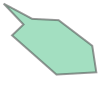

In [9]:
# Convert geometry to shapely object
v1 = shape(first_check["geometry"])
print(first_check["properties"]["borough"])
v1

### Sorting data 
- We sort the data in descending order of the total area of each borough. 
- Then, for each borough, we further sort the zones in descending order of the area of each zone.

In [10]:
# Create a dictionary to store the total area of each borough
borough_areas = {}

# Iterate through the polygons representing boroughs
for feature in features:
    borough_code = feature['properties']['boroughCode']
    polygon = shape(feature['geometry'])
    geom_area = ops.transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat_1=polygon.bounds[1],
            lat_2=polygon.bounds[3]
        )
    ),
    polygon)
    area = geom_area.area
    # If the borough is not in the dictionary, create a new key
    if borough_code not in borough_areas:
        borough_areas[borough_code] = area
    else:
        # Add the new area to the current area of the borough
        borough_areas[borough_code] += area

# Sort the boroughs in descending order of total area
sorted_boroughs = sorted(borough_areas.items(), key=lambda x: x[1], reverse=True)

# List new features after sort
new_features = []

# Iterate through each sorted borough
for borough_code, total_area in sorted_boroughs:
    print(f"Borough Code: {borough_code}, Total Area: {total_area}")

    # Sort the geometries within the borough by decreasing area.
    borough_features = [feature for feature in geojson_data['features'] if feature['properties']['boroughCode'] == borough_code]
    print("Borough: ", borough_features[0]["properties"]["borough"])
    
    sorted_borough_features = sorted(borough_features, key=lambda x: shape(x['geometry']).area, reverse=True)
    new_features.extend(sorted_borough_features)


Borough Code: 4, Total Area: 283354532.24758565
Borough:  Queens
Borough Code: 3, Total Area: 182049468.87353534
Borough:  Brooklyn
Borough Code: 5, Total Area: 150892754.55717745
Borough:  Staten Island
Borough Code: 2, Total Area: 110294139.76927057
Borough:  Bronx
Borough Code: 1, Total Area: 59119007.27194083
Borough:  Manhattan


### The results obtained are as follows: 
- The largest is Queens borough with a total area of 283354532.24758565
- Then the borough of Brooklyn with total area: 182049468.87353534
- The Staten Island borough with total area: 150892754.55717745
- The Bronx borough with total area: 110294139.76927057
- The Manhattan borough with total area: 59119007.27194083

#### We now have a new feature - 'NYC_boroughs' after sorting by borough area and within each borough, sorting by the correct zone (geometry)

## Sample NYC Data

#### Read data and basic information of data

In [11]:
df_taxi = spark.read.option("header", "true").csv('Data/Sample NYC Data.csv')
# Show data 
df_taxi.show(5, truncate=True, vertical=True)

-RECORD 0----------------------------------
 medallion          | 89D227B655E5C82AE... 
 hack_license       | BA96DE419E711691B... 
 vendor_id          | CMT                  
 rate_code          | 1                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 01-01-13 15:11       
 dropoff_datetime   | 01-01-13 15:18       
 passenger_count    | 4                    
 pickup_longitude   | -73.978165           
 pickup_latitude    | 40.757977            
 dropoff_longitude  | -73.989838           
 dropoff_latitude   | 40.751171            
-RECORD 1----------------------------------
 medallion          | 0BD7C8F5BA12B88E0... 
 hack_license       | 9FD8F69F0804BDB55... 
 vendor_id          | CMT                  
 rate_code          | 1                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 06-01-13 0:18        
 dropoff_datetime   | 06-01-13 0:22        
 passenger_count    | 1                    
 pickup_longitude   | -74.006683

In [12]:
# Number of data records
count_records = df_taxi.count()
print("Number of data records: ", count_records)

Number of data records:  99999


In [13]:
df_taxi.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)



### Basic information about data
- The taxi dataset used in this project is a subset of taxi trip data in NYC. 
- This dataset consists of 99999 taxi trips, each with 12 attributes
    - **medallion**:
    - **hack_license**:
    - **vendor_id**: a code indicating the provider associated with the trip record
    - **rate_code**:
    - **store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server — Y=store and forward; N=not a store and forward trip.
    - **pickup_datetime**: date and time when the meter was engaged
    - **dropoff_datetime**: date and time when the meter was disengaged
    - **passenger_count**: the number of passengers in the vehicle (driver entered value)
    - **pickup_longitude**: the longitude where the meter was engaged
    - **pickup_latitude**: the latitude where the meter was engaged
    - **dropoff_longitude**: the longitude where the meter was disengaged
    - **dropoff_latitude**: the latitude where the meter was disengaged

### Process datetime data of columns: 
    - pickup_datetime
    - dropoff_date
- Used the unix_timestamp function to convert the pickup_datetime and dropoff_datetime into milliseconds since epoch time of Unix systems


In [14]:
# convert datatime into milliseconds since epoch using unix_timestamp
data_taxi = df_taxi.withColumn("pickup_ts", lit(None).cast(LongType()))
data_taxi = data_taxi.withColumn("dropoff_ts", lit(None).cast(LongType()))

data_taxi = data_taxi.withColumn("pickup_ts", unix_timestamp(col("pickup_datetime"), "dd-MM-yy H:mm").cast(LongType())*1000)
data_taxi = data_taxi.withColumn("dropoff_ts", unix_timestamp(col("dropoff_datetime"), "dd-MM-yy H:mm").cast(LongType())*1000)

# Compute duration
data_taxi = data_taxi.withColumn("duration", (col("dropoff_ts") - col("pickup_ts")))

In [15]:
data_taxi.show(5, truncate=True, vertical=True)

-RECORD 0----------------------------------
 medallion          | 89D227B655E5C82AE... 
 hack_license       | BA96DE419E711691B... 
 vendor_id          | CMT                  
 rate_code          | 1                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 01-01-13 15:11       
 dropoff_datetime   | 01-01-13 15:18       
 passenger_count    | 4                    
 pickup_longitude   | -73.978165           
 pickup_latitude    | 40.757977            
 dropoff_longitude  | -73.989838           
 dropoff_latitude   | 40.751171            
 pickup_ts          | 1357053060000        
 dropoff_ts         | 1357053480000        
 duration           | 420000               
-RECORD 1----------------------------------
 medallion          | 0BD7C8F5BA12B88E0... 
 hack_license       | 9FD8F69F0804BDB55... 
 vendor_id          | CMT                  
 rate_code          | 1                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 06-01-13 0

###  Perform a search for the borough names of pickup and drop-off points 
- We define a user-defined function (UDFs) named 'get_borough' to perform this. 
- For locations whose names are not found in the NYC boroughs, they will be designated as Unknown


In [17]:
# Ham tim kiem ten quan cua 1 vi tri co kinh do va vi do cho truoc
@udf(StringType())
def get_borough(longitude, latitude):
    point = Point(longitude, latitude)
    borough = "Unknown"
    
    for feature in new_features:
        polygon = shape(feature["geometry"])
        if polygon.contains(point):
            borough = feature["properties"]["borough"]
    return borough

# Tim quan don khac
data_new = data_taxi.withColumn("pickup_borough", get_borough(
    col("pickup_longitude"), col("pickup_latitude")
))

# Tim quan tra khach
data_new = data_new.withColumn("dropoff_borough", get_borough(
    col("dropoff_longitude"), col("dropoff_latitude")
))

# Hiển thị kết quả
data_new.show(3, truncate=True, vertical=True)

-RECORD 0----------------------------------
 medallion          | 89D227B655E5C82AE... 
 hack_license       | BA96DE419E711691B... 
 vendor_id          | CMT                  
 rate_code          | 1                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 01-01-13 15:11       
 dropoff_datetime   | 01-01-13 15:18       
 passenger_count    | 4                    
 pickup_longitude   | -73.978165           
 pickup_latitude    | 40.757977            
 dropoff_longitude  | -73.989838           
 dropoff_latitude   | 40.751171            
 pickup_ts          | 1357053060000        
 dropoff_ts         | 1357053480000        
 duration           | 420000               
 pickup_borough     | Manhattan            
 dropoff_borough    | Manhattan            
-RECORD 1----------------------------------
 medallion          | 0BD7C8F5BA12B88E0... 
 hack_license       | 9FD8F69F0804BDB55... 
 vendor_id          | CMT                  
 rate_code          | 1         

### Data Cleaning

#### Check the null values
- Check the null values for each column to determine how many missing values are in each column

In [ ]:
columns = data_new.columns
for column in columns: 
    check_null = data_new.filter(data_new[column].isNull()).count()
    print(f"Number of null values in {column} column: {check_null}")

Number of null values in medallion column: 0


Number of null values in hack_license column: 0
Number of null values in vendor_id column: 0
Number of null values in rate_code column: 0
Number of null values in store_and_fwd_flag column: 99626
Number of null values in pickup_datetime column: 0
Number of null values in dropoff_datetime column: 0
Number of null values in passenger_count column: 0
Number of null values in pickup_longitude column: 0
Number of null values in pickup_latitude column: 0
Number of null values in dropoff_longitude column: 0
Number of null values in dropoff_latitude column: 0
Number of null values in pickup_ts column: 0
Number of null values in dropoff_ts column: 0
Number of null values in duration column: 0


- Most of the data in column 'store_and_fwd_flag' is missing, so we decided to drop this column.

In [ ]:
data_new = df_new.drop("store_and_fwd_flag")
data_new.printSchema()

#### Check duplicates

In [ ]:
print(f"Number of duplicate records: {data_new.count - data_new.distinct().count()}"")

### Check columns: 
- rate_code
- vendor_id
- passenger_count

In [ ]:
checking_columns = ["rate_code", "vendor_id", "passenger_count"]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for column, ax in zip(checking_columns, axs.ravel()):
    check_1 = data_new.groupBy(column).count().toPandas()
    check_1 = check_1.sort_values(by=column)
    #print(check_1)
    
    ax.bar(check_1[column], check_1["count"])
    ax.set_xlabel(column)
    ax.set_title(f"{column} Distribution")

- Each taxi, when performing a trip, must have one or more passengers. 
- Therefore we check and remove records with less than 1 passenger (namely 0)


In [ ]:
data_new = data_new.filter(data_taxi["passenger_count"] > 0)
data_new.count()

#### Remove records with pickup and drop-off locations not within the 5 boroughs of NYC (Unknown)

In [ ]:
data_new = data_new.filter(col("pickup_borough") != "Unknown")
data_new = data_new.filter(col("dropoff_borough") != "Unknown")
data_new.show(5, truncate=True, vertical=True)

#### We will remove records with negative duration and those exceeding 4 hours (14400000 milliseconds)


In [ ]:
# Filter the trips which has duration > 4x3600*1000 or < 0
duration_threshold = 4*3600*1000 #(miliseconds)
data_new_1 = data_new.filter(col("duration") >= 0)
data_new_1 = data_new_1.filter(col("duration") < duration_threshold)
data_new_1.show(5, truncate=True, vertical=True)
print(f" Number of data records after cleaning: {data_taxi_1.count()}"")

### In each driver's case, remove the records where the pickup time occurs before the drop-off time of the preceding trip
- we expect that the pickup time of a trip must occur after the drop-off time of the preceding trip. 
- This means a trip must be completed before another one can start. 
- Therefore, we sort the trips for each driver by their start time and then remove the records where the pickup time occurs before the drop-off time of the preceding trip and remove the records where the pickup time occurs before the drop-off time of the preceding trip


In [ ]:
# Sort data by pickup_time start time of each driver
windowSpec = Window.partitionBy("hack_license").orderBy("pickup_ts")
data_new_1 = data_new_1.withColumn("previous", lag(col("dropoff_ts")).over(windowSpec))

# Remove trips where the next trip's pickup_time occurs before the previous trip's dropoff_time
data_cleaned = data_new_sorted.filter(col("previous").isNull() | (col("pickup_ts") >= col("previous")))
data_cleaned.count()
data_cleaned.show(5, truncate=True, vertical=True)

## Perform queries and compute

- **Utilization**: This is per taxi/driver. This can be computed by computing the idle time per taxi
**Computer idle time**

In [3]:
windowSpec = Window.partitionBy("hack_license").orderBy("pickup_ts")
data_query_1 = data_cleaned.withColumn("previous", lag(col("dropoff_ts")).over(windowSpec))


data_query_1 = data_query_1.withColumn("idle_time", col("pickup_ts") - col("previous"))

# Remove records with a waiting time greater than 4 hours
threshold = 4*3600*1000
data_final = data_query_1.filter(col("idle_time") <= threshold)

# computing the idle time per taxi
result_q1_by_taxi = data_final.groupBy("hack_license").agg({"idle_time": "sum"})

# computing the idle time per borough
result_q1_by_borough = data_final.groupBy("dropoff_borough").agg({"idle_time": "sum"})

NameError: name 'data_cleaned' is not defined

In [ ]:
result_q1_by_taxi.show()

In [ ]:
result_q1_by_borough.show()

### Compute 2: 
- **The average time** it takes for a taxi to find its next fare(trip) per destination borough. This is can be computed by finding the difference of time, e.g. in seconds, between the drop off a trip and the pick up of the next trip.

In [ ]:
# Calculate the average waiting time for each destination district
average_wait_time = data_cleaned.groupBy("dropoff_borough") \
                             .agg({"idle_time": "avg"}) \
                             .withColumnRenamed("avg(idle_time)", "average_wait_time")

average_wait_time.show()

### Compute 3 and 4: 
- The number of trips that started and ended within the **same borough**
- The number of trips that started in one borough and ended in another one

In [ ]:
# Compute 1: 
# The number of trips that started and ended within the same borough
same_borough_trips = data_final.filter(col("pickup_borough") == col("dropoff_borough")).count()

# The number of trips that started in one borough and ended in another one
different_borough_trips = data_final.filter(col("pickup_borough") != col("dropoff_borough")).count()

# Sgo
average_wait_time.show()
print("Number of trips that started and ended within the same borough:", same_borough_trips)
print("Number of trips that started in one borough and ended in another one:", different_borough_trips)